In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import dlib
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/Colab Notebooks/shape_predictor_68_face_landmarks.dat') # Initialize the landmark model


In [ ]:
#####################################################


FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

In [ ]:
def get_landmarks(im):
    rects = detector(im, 1)

    if len(rects) > 1:
        print("many faces")
    if len(rects) == 0:
        print("no faces")

    else:
      return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

In [ ]:
def read_im_and_landmarks(fname):
    im = cv2.imread(fname, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (im.shape[1] ,
                         im.shape[0] ))
    s = get_landmarks(im)

    return im, s

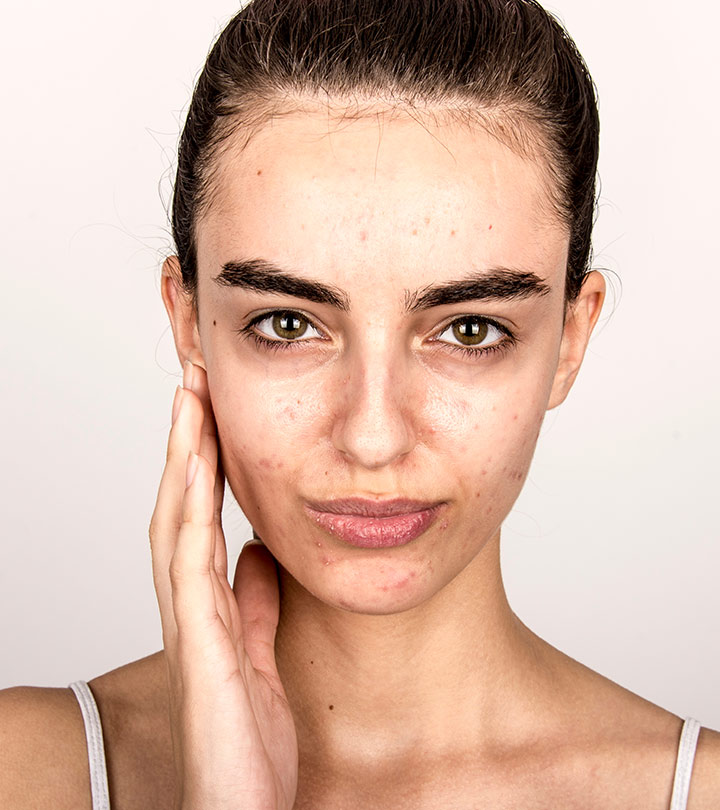

In [ ]:
img, landmarks = read_im_and_landmarks("/content/face.jpg")
cv2_imshow(img)

In [ ]:
img_height, img_width = img.shape[0:2] #get the image height and width. Image data is in the format of [height, width, channel]
"""min_dim = min(img_height, img_width)
min_face_size = min_dim * 0.2 # Specify the minimal face size. Heuristic.
min_eye = min_face_size * 0.2 # specify the minimal eye size.
"""

face_x_min = int(max(0, np.asarray(min(landmarks[:,0])).flatten()[0])) #Get the minimal value of the detected landmarks in x
face_x_max = int(min(img_width, np.asarray(max(landmarks[:,0])).flatten()[0])) # Get the maximal value of the detected landmarks in x
face_y_min = int(max(0, np.asarray(min(landmarks[:,1])).flatten()[0])) # Get the minimal value of the detected landmarks in y
face_y_max = int(min(img_height, np.asarray(max(landmarks[:,1])).flatten()[0])) # Get the maximal value of the detected landmarks in y
face_height = face_y_max - face_y_min # Get the height of face
forehead_height = int(face_height * 0.3) # Ideally, forehead height should be 1/2 of the height between eyebrow and bottom of chin
                                                    # We choose forehead_ratio = 0.3 to avoid hairs on the forehead.
new_face_y_min = max(0, face_y_min - forehead_height) # new_face_y_min is the top edge of the forehead.
right_brow_landmarks = landmarks[RIGHT_BROW_POINTS,:]
left_brow_landmarks = landmarks[LEFT_BROW_POINTS,:]
right_eye_landmarks = landmarks[RIGHT_EYE_POINTS,:]
left_eye_landmarks = landmarks[LEFT_EYE_POINTS,:]
mouse_landmarks = landmarks[MOUTH_POINTS,:]
nose_landmarks = landmarks[NOSE_POINTS,:]

In [ ]:
def extract_cheek_region(face_x_min, face_x_max, face_y_max, eye_landmarks, left_or_right):
    if left_or_right == "Left":
        cheek_region_min_x = eye_landmarks[0,0] # left cheek, x direction, cheek starts at the most inner point of left eye,
                                                # and ends with the face_x_max - a margin value. The margin value is 0.05 *
                                                # (face_x_max - most inner point of left eye). This margin is set to avoid hair
                                                # or other backgrounds
        cheek_region_max_x = int(face_x_max - 0.2*  (face_x_max - min(eye_landmarks[:,0])))
    else:
        cheek_region_max_x = eye_landmarks[3, 0] # right cheek, x direction, cheek starts at the face_x_min + a margin,
                                                  # where the margin is 0.1 * (cheek_region_max_x - face_x_min). This margin is set
                                                  # to avoid hair or other backgrounds, and ends at the most inner point of right eye
        cheek_region_min_x = int(face_x_min + 0.2* (cheek_region_max_x - face_x_min))
    # y direction, cheek starts at lowest eye landmarks + 0.2 * eye height. 0.2 * eye height is to avoid the skin that might be
    # dominated by eyelash

    cheek_region_min_y = int(max(eye_landmarks[:,1]) + 1.8 * (max(eye_landmarks[:,1])  - min(eye_landmarks[:,1])))
    cheek_region_max_y = int(face_y_max - 0.5 * (face_y_max - max(eye_landmarks[:,1])))
    return [cheek_region_min_x, cheek_region_min_y, cheek_region_max_x, cheek_region_max_y]

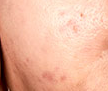

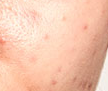

In [ ]:
##########################
# Get the cheeks patch
##########################

left_eye_width = np.max(np.array(left_eye_landmarks[:,0])) - np.min(np.array(left_eye_landmarks[:,0]))
right_eye_width = np.max(np.array(right_eye_landmarks[:,0])) - np.min(np.array(right_eye_landmarks[:,0]))




right_cheek_region = extract_cheek_region(face_x_min, face_x_max, face_y_max, right_eye_landmarks, "Right")
right_cheek_region = img[right_cheek_region[1]: right_cheek_region[3], right_cheek_region[0]:right_cheek_region[2], :]

cv2_imshow(right_cheek_region)


left_cheek_region = extract_cheek_region(face_x_min, face_x_max, face_y_max, left_eye_landmarks, "Left")
left_cheek_region = img[left_cheek_region[1]:left_cheek_region[3], left_cheek_region[0]:left_cheek_region[2], :]
#cheek_file_name = "/content/_lc.jpg"
#left_cheek_region = cv2.cvtColor(left_cheek_region, cv2.COLOR_BGR2RGB)
cv2_imshow(left_cheek_region)
#imageio.imwrite(cheek_file_name, cheek_region)
#cv2_imshow(img)


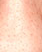

In [ ]:

nose_region_min_x = int(min(nose_landmarks[:, 0]) * 1.07)
nose_region_max_x = int(max(nose_landmarks[:, 0]) * 1.03)
nose_region_min_y = int(min(nose_landmarks[:, 1]) *1.2)
nose_region_max_y = int(max(nose_landmarks[:, 1]) * 0.95)


# Extract and save the nose region
nose_region = img[nose_region_min_y:nose_region_max_y, nose_region_min_x:nose_region_max_x]
cv2_imshow( nose_region)

In [ ]:
nose_region.shape
gray = cv2.cvtColor(nose_region, cv2.COLOR_BGR2GRAY)
gray.shape

(52, 42)

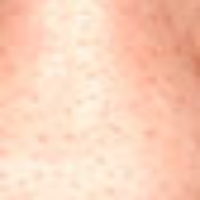

In [ ]:
nose_region_resized= cv2.resize(nose_region,(200,200))
cv2_imshow(nose_region_resized)

In [ ]:

import copy
def detect_blackheads(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    cv2_imshow(blurred)
    # Apply adaptive thresholding
    thresholded = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2
    )
    cv2_imshow(thresholded)
    # Perform morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    thresholded = cv2.erode(thresholded, kernel, iterations=1)
    thresholded = cv2.dilate(thresholded, kernel, iterations=2)
    cv2_imshow(thresholded)
    # Find contours
    contours, _ = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # Count and draw contours around blackheads
    blackhead_count = 0
    im=copy.copy(image)
    for contour in contours:
        # Calculate the average pixel intensity within the contour
        mask = np.zeros(gray.shape, dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        mean_intensity = cv2.mean(gray, mask=mask)[0]

        if mean_intensity > 225:
            cv2.drawContours(im, contour, -1, (0, 0, 255), 2)
            blackhead_count += 1

    # Display the result
    #cv2.putText(image, f'Blackheads: {blackhead_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2_imshow(im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return blackhead_count


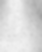

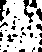

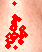

Number of blackheads detected in the nose: 13


In [ ]:
nose_blackhead_count = detect_blackheads(nose_region)
print(f'Number of blackheads detected in the nose: {nose_blackhead_count}')



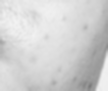

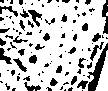

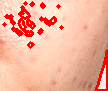

Number of blackheads detected in the left cheek: 25


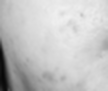

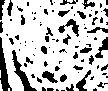

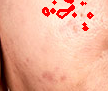

Number of blackheads detected in the right cheek: 13


In [ ]:
left_blackhead_count = detect_blackheads(left_cheek_region)
print(f'Number of blackheads detected in the left cheek: {left_blackhead_count}')
right_blackhead_count = detect_blackheads(right_cheek_region)
print(f'Number of blackheads detected in the right cheek: {right_blackhead_count}')



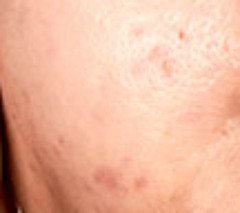

In [ ]:
right_cheek= cv2.resize(right_cheek_region,(240,213))
cv2_imshow(left_cheek)

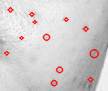

Number of detected blackheads in the left cheek: 12


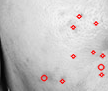

Number of detected blackheads in the right cheek: 10


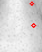

Number of detected blackheads in the nose: 2


In [ ]:
def detect_Cheek_blackheads(image):
      gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      # Set up the blob detector parameters
      params = cv2.SimpleBlobDetector_Params()
      params.minThreshold = 0
      params.maxThreshold = 230
      params.filterByArea = True
      params.minArea = 5
      params.filterByCircularity = False
      params.filterByConvexity = False
      params.filterByInertia = False

      # Create the blob detector
      detector = cv2.SimpleBlobDetector_create(params)

      # Detect blobs in the image
      keypoints = detector.detect(image)

      # Get the count of detected blackheads
      num_blackheads = len(keypoints)


      # Create a copy of the original image for drawing keypoints
      image_with_keypoints = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)

      # Draw the detected keypoints on the image
      cv2.drawKeypoints(image_with_keypoints, keypoints, image_with_keypoints, (0, 0, 255),
                        cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
      # Display the image with keypoints
      cv2_imshow(image_with_keypoints)
      return num_blackheads
n= detect_Cheek_blackheads(left_cheek_region)
print(f"Number of detected blackheads in the left cheek: {n}")
n1= detect_Cheek_blackheads(right_cheek_region)
print(f"Number of detected blackheads in the right cheek: {n1}")
n2= detect_Cheek_blackheads(nose_region)
print(f"Number of detected blackheads in the nose: {n2}")

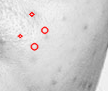

Number of detected blackheads in the left cheek: 4


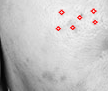

Number of detected blackheads in the right cheek: 6


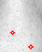

Number of detected blackheads in the nose: 2


In [ ]:
def detect_Cheek_blackheads(image, intensity_threshold):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Set up the blob detector parameters
    params = cv2.SimpleBlobDetector_Params()
    params.minThreshold = 40
    params.maxThreshold = 240
    params.filterByArea = True
    params.minArea = 5
    params.filterByCircularity = False
    params.filterByConvexity = False
    params.filterByInertia = False

    # Create the blob detector
    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs in the image
    keypoints = detector.detect(image)

    # Filter keypoints based on intensity threshold
    filtered_keypoints = []
    for keypoint in keypoints:
        x, y = int(keypoint.pt[0]), int(keypoint.pt[1])
        intensity = gray_image[y, x]
        if intensity > intensity_threshold:
            filtered_keypoints.append(keypoint)

    # Get the count of detected blackheads
    num_blackheads = len(filtered_keypoints)

    # Create a copy of the original image for drawing keypoints
    image_with_keypoints = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)

    # Draw the detected keypoints on the image
    cv2.drawKeypoints(image_with_keypoints, filtered_keypoints, image_with_keypoints, (0, 0, 255),
                      cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Display the image with keypoints
    cv2_imshow(image_with_keypoints)

    return num_blackheads

intensity_threshold = 220  # Adjust this threshold as needed
n = detect_Cheek_blackheads(left_cheek_region, intensity_threshold)
print(f"Number of detected blackheads in the left cheek: {n}")
n1 = detect_Cheek_blackheads(right_cheek_region, intensity_threshold)
print(f"Number of detected blackheads in the right cheek: {n1}")
n2 = detect_Cheek_blackheads(nose_region, intensity_threshold)
print(f"Number of detected blackheads in the nose: {n2}")


Number of detected blackheads in the right cheek: 13


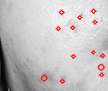

In [ ]:
gray_image = cv2.cvtColor(right_cheek_region, cv2.COLOR_BGR2GRAY)
# Set up the blob detector parameters
params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 0
params.maxThreshold = 240
params.filterByArea = True
params.minArea = 5
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia = False

# Create the blob detector
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs in the image
keypoints = detector.detect(right_cheek_region)

# Get the count of detected blackheads
num_blackheads = len(keypoints)
print(f"Number of detected blackheads in the right cheek: {num_blackheads}")

# Create a copy of the original image for drawing keypoints
image_with_keypoints = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)

# Draw the detected keypoints on the image
cv2.drawKeypoints(image_with_keypoints, keypoints, image_with_keypoints, (0, 0, 255),
                  cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# Display the image with keypoints
cv2_imshow(image_with_keypoints)

In [ ]:
!pip3 install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 34.2 MB/s eta 0:00:00


In [ ]:
import base64
from PIL import Image
from io import BytesIO
import mediapipe as mp
import math
import numpy as np
import cv2

In [ ]:
def base64_to_np(image_data):
    # Decode the base64-encoded image data and convert it to a NumPy array
    decoded_bytes = base64.b64decode(image_data)
    img_np = np.array(Image.open(BytesIO(decoded_bytes)))
    return img_np

In [ ]:
def base64_to_np1(image_data):
    try:
        # Decode the base64-encoded image data and convert it to a NumPy array
        decoded_bytes = base64.b64decode(image_data)

        # Explicitly specify the format (e.g., JPEG)
        img = Image.open(BytesIO(decoded_bytes))

        img_np = np.array(img)
        return img_np

    except Exception as e:
        print(f"Error converting base64 to NumPy: {e}")
        return None


In [ ]:
def decode(encoded_img):
    aux_path = '/tmp/tmp.png'
    with open(aux_path, "wb") as f:
        f.write(base64.b64decode(encoded_img))
        f.close()

    out = cv2.imread(aux_path)

    return out

In [ ]:
def find_landmark(image_data,coords):
    #image = base64_to_np(image_data)
    #imge = cv2.imread(image)
    image_width, image_height = image_data.shape[1], image_data.shape[0]
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
    results = face_mesh.process(cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB))
    landmarks = results.multi_face_landmarks[0]
    landmark_point = []
    for index, landmark in enumerate(landmarks.landmark):
        if landmark.visibility < 0 or landmark.presence < 0:
            continue
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        landmark_point.append((landmark_x, landmark_y))
    return landmark_point[coords]

In [ ]:
# Read the Base64 string from the file
with open('/content/image.txt', 'r') as file:
    base64_string = file.read()
image_data = decode(base64_string)
# Decode the Base64 string
#image_data = base64.b64decode(base64_string)

In [ ]:
pores_colors = (255, 250, 134)

In [ ]:
image_data.shape

(1024, 1024, 3)

In [ ]:
image_data

array([[[206, 211, 209],
        [202, 207, 205],
        [203, 208, 206],
        ...,
        [197, 211, 210],
        [194, 208, 207],
        [195, 209, 208]],

       [[208, 213, 211],
        [205, 210, 208],
        [206, 211, 209],
        ...,
        [200, 214, 213],
        [198, 212, 211],
        [198, 212, 211]],

       [[211, 216, 214],
        [208, 213, 211],
        [208, 213, 211],
        ...,
        [201, 215, 214],
        [200, 214, 213],
        [201, 215, 214]],

       ...,

       [[201, 192, 179],
        [191, 182, 169],
        [199, 190, 177],
        ...,
        [208, 199, 189],
        [198, 189, 179],
        [201, 192, 182]],

       [[199, 190, 177],
        [192, 183, 170],
        [200, 191, 178],
        ...,
        [208, 199, 189],
        [183, 174, 164],
        [199, 190, 180]],

       [[195, 186, 173],
        [191, 182, 169],
        [197, 188, 175],
        ...,
        [218, 209, 199],
        [186, 177, 167],
        [203, 194, 184]]

In [ ]:
def find_landmarks(image, landmarks, area):
    image_width, image_height = image.shape[1], image.shape[0]
    landmark_point = []
    coord = []
    for index, landmark in enumerate(landmarks.landmark):
        if landmark.visibility < 0 or landmark.presence < 0:
            continue
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        landmark_point.append((landmark_x, landmark_y))
    for num in range(len(area)):
        coord.append(landmark_point[area[num]])
    return coord

In [ ]:
area1 =[70,71,21,54,103,67,109,10,338,297,332,284,251,301,300,293,334,296,336,9,107,66,105,63,70]#forehead
area4 = [233,128,114,47,100,119,118,117,31,228,229,230,231,232,233] # under_left_eye (Checked)
area5 = [453,357,343,277,329,348,347,346,261,448,449,450,451,452,453] # under_right_eye (Rectified)

pores_colors = (255, 250, 134)
dark_circles_color = (168, 154, 255)
wrinkles_color = (229, 132, 135)

In [ ]:
def read_image_pores_multiple_areas(image_data, color,areas_colors):
  image_data_ = cv2.imread(image_data)
  point1= find_landmark(image_data_, 50)
  point2= find_landmark(image_data_, 117) #For left radius calc
  point3= find_landmark(image_data_, 280)
  radius = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
  overlay = np.zeros_like(image_data_)
  cv2.circle(overlay, point1, int(radius), color,-1)
  cv2.circle(overlay, point3, int(radius), color,-1)
  result1 = cv2.addWeighted(image_data_, 0.9, overlay, 0.3, 0)

  img = cv2.cvtColor(result1, cv2.COLOR_BGR2RGB)
  mp_face_mesh = mp.solutions.face_mesh
  face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
  results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  landmarks = results.multi_face_landmarks[0]
  mask = np.zeros_like(img)

  for area, color in areas_colors:
      points = find_landmarks(img, landmarks, area)
      cv2.fillPoly(mask, [np.array(points)], color)

  img1 = cv2.addWeighted(img, 0.9, mask, 0.3, 0)
  img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
  _, encoded = cv2.imencode('.png', img1, [cv2.IMWRITE_JPEG_QUALITY, 80])
  cv2.imwrite('face_with_circles.png',img1)

In [ ]:
areas_colors = [(area1, wrinkles_color), (area4, dark_circles_color), (area5, dark_circles_color)]

In [ ]:
read_image_pores_multiple_areas('img.jpeg', pores_colors,areas_colors)

In [ ]:
############################################################################################################

In [ ]:
def read_image_pores(image_data, color):
  image_data1 = cv2.imread(image_data)
  point1= find_landmark(image_data1, 50)
  point2= find_landmark(image_data1, 117) #For left radius calc
  point3= find_landmark(image_data1, 280)
  radius = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
  overlay = np.zeros_like(image_data1)
  cv2.circle(overlay, point1, int(radius), color,-1)
  cv2.circle(overlay, point3, int(radius), color,-1)
  result_img = cv2.addWeighted(image_data1, 0.9, overlay, 0.3, 0)
  cv2.imwrite('/content/face_with_circles1.png',result_img)

In [ ]:
read_image_pores('img.jpeg', pores_colors)

In [ ]:
areas_colors = [(area1, wrinkles_color), (area4, dark_circles_color), (area5, dark_circles_color)]